# Anomaly Detection - Self Organizing Maps 

O presente notebook tem como intuito de abordar o problema de detecção de anomalias através de algoritmos não supervisionados para agrupamento de dados em redes neurais artificiais.
  - Mapas de Kohonem ou Self Organizing Maps

## Imports Necessários

In [12]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from minisom import MiniSom
from matplotlib.gridspec import GridSpec


## Dataset - NAB (Numenta Anomaly Detection)

O dataset mencionado acima, será utilizado para fazer um benchmark dentre modelos. Esse dataset já e bastante conhecido e utilizado para esses mesmos propósitos

### Extração do dataset em um **Data Frame**

Dentre os datasets disponiveis no NAB, o escolhido foi o de **machine_temperature_system_failure**

In [3]:
df = pd.read_csv('machine_temperature_system_failure.csv')
df.sample(5)


,timestamp,value
13527,2014-01-18 19:30:00,92.598541
10633,2014-01-08 18:20:00,86.645920
4417,2013-12-18 05:20:00,102.629798
3572,2013-12-15 06:55:00,99.405577
7853,2013-12-30 03:40:00,86.662068


Realizando algumas mudanças para facilitar a análise gráfica do dataset

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['value'] = (df['value'] -32)*5/9


<AxesSubplot:xlabel='timestamp'>

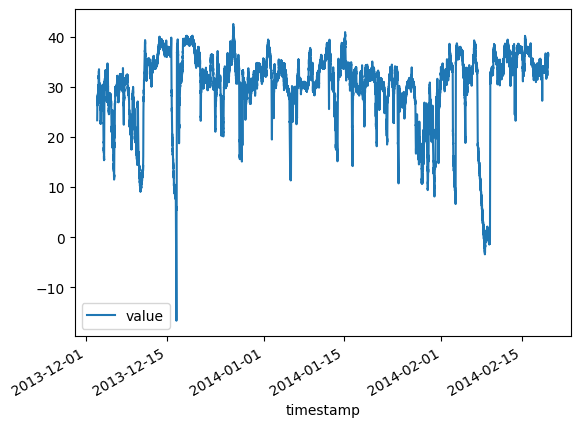

In [5]:
df.plot(x='timestamp',y='value')


Através da extração de alguns dados importantes do dataset, podemos criar novas colunas que irão facilitar na análise dos dados

In [6]:
df['hora'] = df['timestamp'].dt.hour #transformando o timestamp e arrendondado para as horas exatas dos dias
df['dia'] = ((df['hora'] >= 7) & (df['hora'] <= 22)).astype(int) # definindo se a medição foi tirada durante o dia ou a noite se for 1 é dia 0 noite
df['Dia_da_Semana'] = df['timestamp'].dt.dayofweek


### Normalização do dataset

Utilizaremos o StandardScaler devido a menor sensibilidade a outliers do que o MinMaxScaler

In [7]:
std_scaler = preprocessing.StandardScaler()
data_to_scale = df[['value','hora','Dia_da_Semana']]
data_to_scale = pd.DataFrame(std_scaler.fit_transform(data_to_scale))


In [17]:
data_to_scale.columns = ['value','hora','Dia_da_Semana']


In [20]:
df_features = data_to_scale.columns
df_features


Index(['value', 'hora', 'Dia_da_Semana'], dtype='object')

<AxesSubplot:>

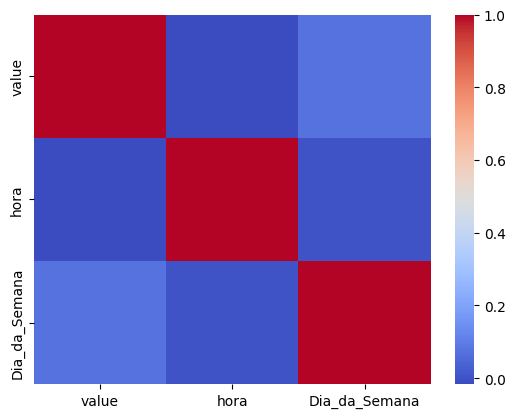

In [19]:
sns.heatmap(pd.DataFrame(data_to_scale).corr(), cmap='coolwarm')


In [33]:
# Utilizando PCA para selecionar as features mais importantes
pca = PCA()
pca.fit(data_to_scale)

W = pca.components_

# Tabela dos componentes de autovalores calculados pelo PCA
W = pd.DataFrame(W.T,
                 columns=df_features)
W


,0,1,2
value,-0.706941,0.002018,-0.707270
hora,0.152981,0.976760,-0.150123
Dia_da_Semana,-0.690530,0.214327,0.690820


Vamos agora projetar nosso dataset nesse novo espaço gerado pelo PCA

In [30]:
X_proj = pca.transform(data_to_scale)
X_proj = pd.DataFrame(X_proj, columns=[f'PC{i}' for i in range(1,4)])
X_proj


,PC1,PC2,PC3
0,1.850179,1.023633,-0.616354
1,1.800369,1.023775,-0.666187
2,1.739260,1.023950,-0.727325
3,1.635556,1.024246,-0.831077
4,1.574403,1.024420,-0.892258
...,...,...,...
22690,-0.219988,0.395699,-1.039859
22691,-0.200382,0.395643,-1.020243
22692,-0.165993,0.395545,-0.985838
22693,-0.213377,0.395680,-1.033244


Podemos agora rankear os PCs de acordo com sua importância.
- A importância de um PC é dada pela relação da variância dos PCs/Cada dado do dataset

In [32]:
X_proj.std()**2 / ((data_to_scale.std()**2).sum())


PC1    0.358743
PC2    0.333310
PC3    0.307947
dtype: float64

O Rank acima mostra por ordem de variância, a sensibilidade de cada feature, vamos selecionar as duas primeiras

In [45]:
df['main_feature1'] = X_proj['PC1']
df['main_feature2'] = X_proj['PC2']


### Definindo o SOM

O tamanho do grid ou mapa, é definido a partir do tamanho de amostras, tendo como cálculo a seguinte abordagem:
 -  grid = 5*sqrt(numero de amostras)
 - No nosso caso temos: 5 * sqrt{22695} -> aprox = 784 ou 28x28

In [135]:
data = X_proj.to_numpy()
data.shape


(22695, 3)

#### SOM 1 com grid 28x28

In [89]:
som = MiniSom(28, 28, X_proj.shape[1], sigma=1, learning_rate=0.5,
              neighborhood_function='gaussian')
som.random_weights_init(data)
som.train_random(data, num_iteration=30000,verbose=True)


 [ 30000 / 30000 ] 100% - 0:00:00 left 
 quantization error: 0.10945114858228149


#### SOM 2 com grid 14x14

In [122]:
som2= MiniSom(14, 14, X_proj.shape[1], sigma=1, learning_rate=0.65,
              neighborhood_function='gaussian')
som2.random_weights_init(data)
som2.train_random(data, num_iteration=30000,verbose=True)


 [ 30000 / 30000 ] 100% - 0:00:00 left 
 quantization error: 0.20805164948016144


### Análise do número de iterações x o QE e TE

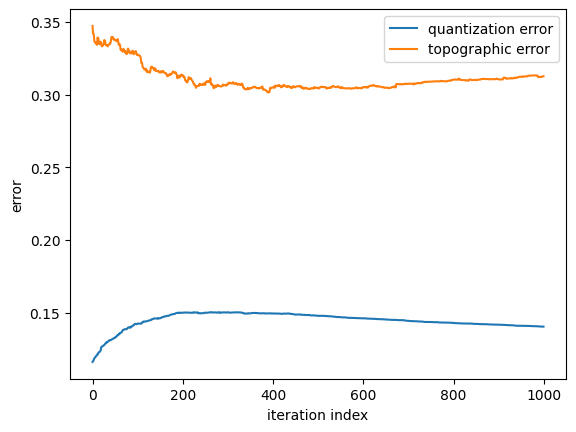

In [91]:
max_iter = 1000
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(data))
    som.update(data[rand_i], som.winner(data[rand_i]), i, max_iter)
    q_error.append(som.quantization_error(data))
    t_error.append(som.topographic_error(data))

plt.plot(np.arange(max_iter), q_error, label='quantization error')
plt.plot(np.arange(max_iter), t_error, label='topographic error')
plt.ylabel('error')
plt.xlabel('iteration index')
plt.legend()
plt.show()


Com o grid calculado a partir da quantidade de linhas, temos um erro quântico bem menor ao comparado abaixo, porém com custo computacional bem mais elevado.

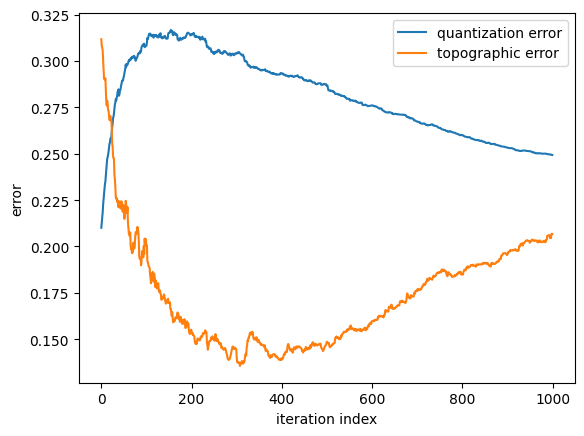

In [123]:
max_iter = 1000
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(data))
    som2.update(data[rand_i], som2.winner(data[rand_i]), i, max_iter)
    q_error.append(som2.quantization_error(data))
    t_error.append(som2.topographic_error(data))

plt.plot(np.arange(max_iter), q_error, label='quantization error')
plt.plot(np.arange(max_iter), t_error, label='topographic error')
plt.ylabel('error')
plt.xlabel('iteration index')
plt.legend()
plt.show()


Com o grid menor, vemos que ambos erros seguem o mesmo padrão, porém aqui eles se encontram e tendem a convergir com níveis parecidos de erro. A diminuição do grid aumentou o erro quantico porém não causou impacto negativo no erro topográfico, ou seja a representação topográfica dos nós (pesos) não foi afetada.

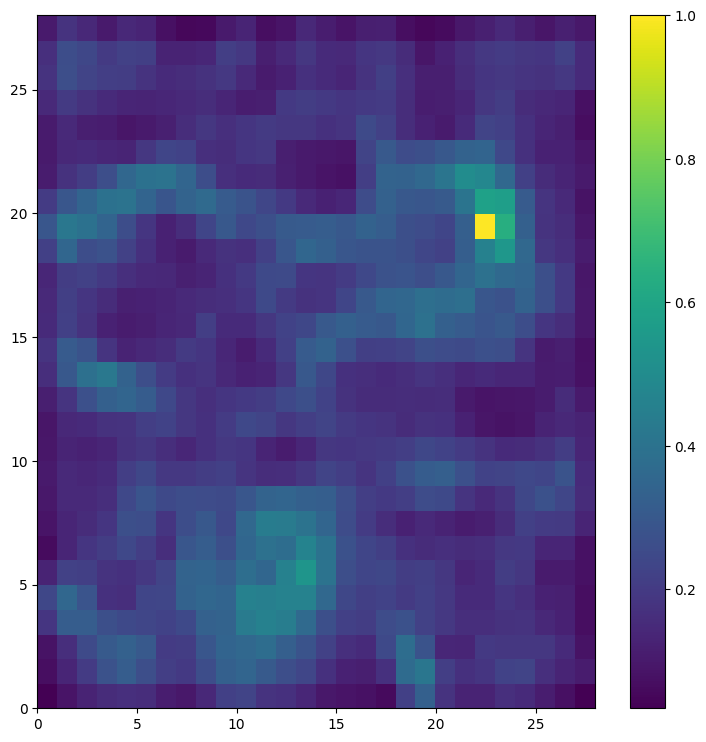

In [142]:
%matplotlib inline

plt.figure(figsize=(9, 9))

plt.pcolor(som.distance_map().T)  # plotting the distance map as background
plt.colorbar()

c = y.astype('category').cat.codes



# # Plotting the response for each pattern in the iris dataset
# # different colors and markers for each label
# markers = ['o', 's']
# colors = ['C0', 'C1']
# for cnt, xx in enumerate(data):
#     w = som.winner(xx)  # getting the winner
#     # palce a marker on the winning position for the sample xx
#     plt.plot(w[0]+.5, w[1]+.5, markers[c[cnt]-1], markerfacecolor='None',
#              markeredgecolor=colors[c[cnt]-1], markersize=12, markeredgewidth=2)

# plt.show()


Nas áreas mais escuras azuladas, os neuronios estão mais próximos um dos outros, nos pontos mais claros, os neurônios estão mais distantes uns dos outros. Podemos ver essa relação na sobreposição dos Weight vectors sobre o conjunto de dados, logo abaixo.

Análise dos  ***Node Weight Vectors***

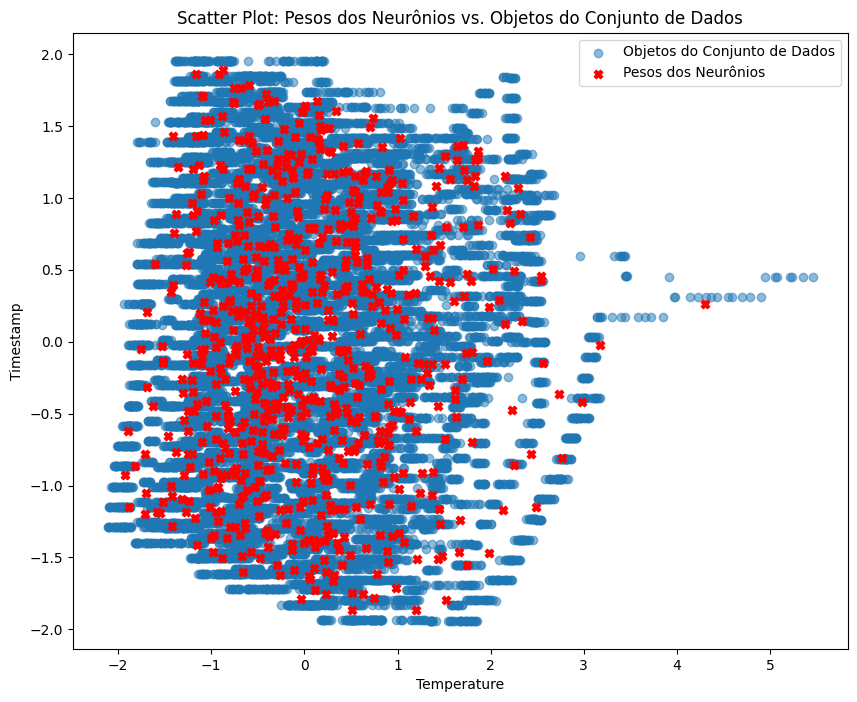

In [138]:
weights = som.get_weights()

data_dim1 = df['main_feature1'] # Sepal Length
data_dim2 = df['main_feature2'] # Sepal Width



weights_dim1 = weights[:, :, 0].flatten()
weights_dim2 = weights[:, :, 1].flatten()



plt.figure(figsize=(10, 8))
plt.scatter(data_dim1, data_dim2, label='Objetos do Conjunto de Dados', alpha=0.5)
plt.scatter(weights_dim1, weights_dim2, label='Pesos dos Neurônios', marker='X', color='red')
plt.title('Scatter Plot: Pesos dos Neurônios vs. Objetos do Conjunto de Dados')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.legend()
plt.show()


***Weight Vectors x Conjunto de Dados*** para SOM de grid 14x14

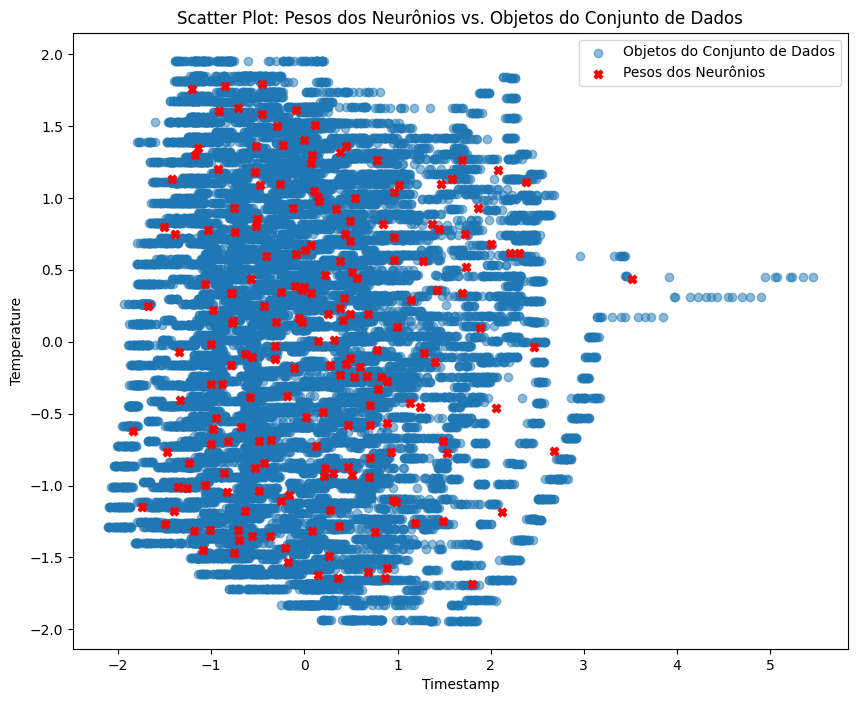

In [140]:
weights = som2.get_weights()

data_dim1 = data[:, 0] # Sepal Length
data_dim2 = data[:, 1] # Sepal Width
data_dim3 = data[:, 2] # Petal length


weights_dim1 = weights[:, :, 0].flatten()
weights_dim2 = weights[:, :, 1].flatten()
weights_dim3 = weights[:, :, 2].flatten()


plt.figure(figsize=(10, 8))
plt.scatter(data_dim1, data_dim2, label='Objetos do Conjunto de Dados', alpha=0.5)
plt.scatter(weights_dim1, weights_dim2, label='Pesos dos Neurônios', marker='X', color='red')
plt.title('Scatter Plot: Pesos dos Neurônios vs. Objetos do Conjunto de Dados')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.legend()
plt.show()


### Anomaly Detection with KNN

In [ ]:
def get_anomalies(safe_metrics, anomaly_metrics,alpha=3):

    limit = np.mean(safe_metrics) + np.std(safe_metrics)*alpha
    outliers = np.argwhere(np.abs(anomaly_metrics) > limit)
    print("Determined:", len(outliers)/len(anomaly_metrics)*100," as anomalies")
    return outliers
